<a href="https://colab.research.google.com/github/krithiyer/safe-elections/blob/main/cs294s_1A_QQP_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


train.csv (training data from Quora Duplicate questions dataset is replicated in local drive at cs294s dir). The same dir also used for saving fine-tuned models

In [ ]:
cd /content/drive/My Drive/cs294s/

/content/drive/My Drive/cs294s


Step 1: Fine tuning on Quora Question Pair Dataset
More information on the dataset available at

https://www.kaggle.com/c/quora-question-pairs

Using pandas to read the question dataset and exploring the dataset a bit - reading only 5K question pairs for the initial explroation

QQ pair dataset has 404,290 questions in the training set and 2,345,795 questions in the test set.

Note: 3 questions in the dataset contain NaN values. This causes problems during downstream model training. The 3 question paris with NaN values are removed from the dataset.

In [ ]:
import pandas
import torch

quora_questions_dataset = pandas.read_csv("train.csv", nrows=5000)
quora_questions_dataset.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
quora_questions_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            5000 non-null   int64 
 1   qid1          5000 non-null   int64 
 2   qid2          5000 non-null   int64 
 3   question1     5000 non-null   object
 4   question2     5000 non-null   object
 5   is_duplicate  5000 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 234.5+ KB


There are 3 entries with NaN value - causes problem downstream - remove these entries.

In [ ]:
proc_dataset = quora_questions_dataset.dropna()

In [ ]:
proc_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            5000 non-null   int64 
 1   qid1          5000 non-null   int64 
 2   qid2          5000 non-null   int64 
 3   question1     5000 non-null   object
 4   question2     5000 non-null   object
 5   is_duplicate  5000 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 273.4+ KB


Save the labels in proc_labels

In [ ]:
proc_labels = proc_dataset.is_duplicate.values

###Step 2: Tokenize the input data

Use BERT tokenizer



Tokenize questions, get summary stats on the length of tokens per question so we can determine model parameters (sequence length, etc)

In [ ]:
pip install transformers

In [ ]:
import torch
import transformers
#from transformers import BertTokenizer

#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

explore the tokenizer a bit  (we can also change the tokenizers)

In [ ]:
print(f"Original: {quora_questions_dataset['question1'][0]}")
print(f"Tokenized: {tokenizer.tokenize(quora_questions_dataset['question1'][0])}")
print(f"Token IDs: {tokenizer.convert_tokens_to_ids(tokenizer.tokenize(quora_questions_dataset['question1'][0]))}")

Original: What is the step by step guide to invest in share market in india?
Tokenized: ['what', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', 'in', 'india', '?']
Token IDs: [2054, 2003, 1996, 3357, 2011, 3357, 5009, 2000, 15697, 1999, 3745, 3006, 1999, 2634, 1029]


In [ ]:
print(f"Original: {quora_questions_dataset['question2'][0]}")
print(f"Tokenized: {tokenizer.encode(quora_questions_dataset['question2'][0])}")

Original: What is the step by step guide to invest in share market?
Tokenized: [101, 2054, 2003, 1996, 3357, 2011, 3357, 5009, 2000, 15697, 1999, 3745, 3006, 1029, 102]


convert tokens to words

In [ ]:
tokenizer.decode([101, 2054, 2003, 1996, 3357, 2011, 3357, 5009, 2000, 15697, 1999, 3745, 3006, 1029, 102])

'[CLS] what is the step by step guide to invest in share market? [SEP]'

###length of questions

We need to find the maximum length of questions (if we use wordpair or bytepair tokenizer, etc., legnth of tokens / question can be longer than words per question) 

following needs a tokenizer  


In [ ]:
from tqdm import tqdm

tqdm.pandas()
quora_questions_dataset["question1_length"] = quora_questions_dataset["question1"].progress_apply(lambda question: 
                                                                                      len(tokenizer.tokenize(question)))
quora_questions_dataset["question2_length"] = quora_questions_dataset["question2"].progress_apply(lambda question: 
                                                                                      len(tokenizer.tokenize(question)))
quora_questions_dataset["joint_length"] = quora_questions_dataset["question1_length"] + quora_questions_dataset["question2_length"]
print('\n')
print ("max length of questions in the quora dataset *** ")
quora_questions_dataset["joint_length"].max()

100%|██████████| 5000/5000 [00:00<00:00, 5043.10it/s]



max length of questions in the quora dataset *** 


310

THE FOLLOWING EXPERIMENTATION WITH TOKENIZER

Segment label - sentence 1 is segment A, sentence 2 is segment B
and put the label

check for first SEP token - upto that pont it is segment A.

In [ ]:
num_rows = quora_questions_dataset.shape[0]
input_ids = []
attention_masks = []
encoded_dict ={}
#for i in range(num_rows):
for i in range (5):
  encoded_dict = tokenizer.encode_plus(
                    quora_questions_dataset['question1'][i],
                    quora_questions_dataset['question2'][i],
                    add_special_tokens = True,
                    truncation=True,
                    max_length = 512,
                    pad_to_max_length = True,
                    return_token_type_ids = True,
                    return_attention_mask = True,
  )
  print (encoded_dict["input_ids"])
  print (encoded_dict["token_type_ids"])
  print ("reverse_sentence  ", tokenizer.decode(encoded_dict['input_ids']))
  # return_tensors = 'pt'


[101, 2054, 2003, 1996, 3357, 2011, 3357, 5009, 2000, 15697, 1999, 3745, 3006, 1999, 2634, 1029, 102, 2054, 2003, 1996, 3357, 2011, 3357, 5009, 2000, 15697, 1999, 3745, 3006, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
for i in range (5):
  # print ("input tokenized : ")
  #combined_text = quora_questions_dataset['question1'][i] + "[SEP]" + quora_questions_dataset['question2'][i] 
  #print ("input tokenized : ", tokenizer.tokenize(quora_questions_dataset['question1'][i], quora_questions_dataset['question2'][i] ))
  encoded_dict = tokenizer(quora_questions_dataset['question1'][i], quora_questions_dataset['question2'][i])
  print (encoded_dict)
  print ("reverse_sentence  ", encoded_dict['token_type_ids'])
  print ("reverse_sentence  ", tokenizer.decode(encoded_dict['input_ids']))
  

{'input_ids': [101, 2054, 2003, 1996, 3357, 2011, 3357, 5009, 2000, 15697, 1999, 3745, 3006, 1999, 2634, 1029, 102, 2054, 2003, 1996, 3357, 2011, 3357, 5009, 2000, 15697, 1999, 3745, 3006, 1029, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
reverse_sentence   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
reverse_sentence   [CLS] what is the step by step guide to invest in share market in india? [SEP] what is the step by step guide to invest in share market? [SEP]
{'input_ids': [101, 2054, 2003, 1996, 2466, 1997, 12849, 10606, 16506, 1006, 12849, 2232, 1011, 1045, 1011, 2053, 2953, 1007, 6323, 1029, 102, 2054, 2052, 4148, 2065, 1996, 2796, 2231, 10312, 1996, 12849, 10606, 16506, 1006, 12849, 2232, 1011, 1045, 1011, 2053, 2953, 1007, 6323, 2067, 1029, 102], 

Covert input dataset into tokenized input ids (for fine-tuning the model)

In [ ]:
import torch # move to a different cell
num_rows = proc_dataset.shape[0]

input_ids = []
attention_masks = []
token_type_ids = []
temp_labels = []
for row in proc_dataset.itertuples():
  encoded_dict = tokenizer.encode_plus(
                    row.question1,
                    row.question2,
                    add_special_tokens = True,
                    truncation=False,
                    max_length = 510,
                    padding = 'max_length',
                    return_token_type_ids = True,
                    return_attention_mask = True,
                    return_tensors = 'pt'
  )
  # Add the encoded sentence to the list.    
  input_ids.append(encoded_dict['input_ids'])
  attention_masks.append(encoded_dict['attention_mask'])
  token_type_ids.append (encoded_dict["token_type_ids"])
  # Token type ids to separate the two sentences

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
token_type_ids = torch.cat(token_type_ids, dim=0)
labels = torch.Tensor(proc_labels).type(torch.LongTensor)



###Step 2.1 Split the Dataset into Training and Validation sets

and store the dataset in pytorch tensor format.

In [ ]:
from torch.utils.data import TensorDataset, random_split
dataset = TensorDataset(input_ids,  attention_masks,  token_type_ids, labels )

train_val_split = 0.9
train_size = int(train_val_split * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

4,500 training samples
  500 validation samples


Save the dataset for use in the future (for different experiments with the fine tuning of the model)

In [ ]:
torch.save (dataset, "./dataset.pt")

##Step 2.2 Load Saved Dataset 

For additional experiments with fine-tuning, we can simply load the preprocessd dataset.

In [ ]:
data_test_xx = torch.load("./dataset.pt")

NameError: ignored

In [ ]:
import torch
from torch.utils.data import TensorDataset, random_split

# ******
# USE WITH SAVED dataset
# ********

#dataset = TensorDataset(input_ids,  attention_masks,  token_type_ids, labels )
dataset = torch.load("./dataset.pt")

train_val_split = 0.9
train_size = int(train_val_split * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

363,858 training samples
40,429 validation samples


Split the data into training / validation steps

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

### Step 3: Fine-tune the Model

Fine tune the basic BertForSequenceClassification model using the QQP dataset

More information on model parameters at:

https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification

More info on model output

https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput

More information on finetuning

https://huggingface.co/transformers/training.html



During training, after one epoch, the GPU would run out of memory. So the model was saved after one epoch, loaded again and trained for the 2nd epoch and so on.

For the 1st epoch, use BertForTokenClassification.from_pretrained('bert-base-uncased'  -- the base model.

For subsequent epochs, use the saved model from the previous epoch.

-- will investigate the use of pytorch dataset to avoid this memory problem.


In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    './models_saved_qqp_oct9C/'
, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2  # using a model that was already trained 1 epoch.

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Traing the model

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []
loss_values = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    


    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. 

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 500 batches.
        if step % 500 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU 
  
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_token_type_ids = batch[2].to(device)
        b_labels = batch[3].to(device)
 
        
        # Clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 

        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
 
        outputs = model(b_input_ids, 
                             attention_mask=b_input_mask, 
                             token_type_ids=b_token_type_ids,
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
   
        loss = outputs[0]
        logits = outputs[1]
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    loss_values.append(avg_train_loss)
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_token_type_ids = batch[2].to(device)
        b_labels = batch[3].to(device)
 
        # Tell  pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
   
            val_outputs = model(b_input_ids, 
                                attention_mask=b_input_mask, 
                                token_type_ids=b_token_type_ids, 
                                labels = b_labels)
                                   
        loss = val_outputs[0]
        logits = val_outputs[1]          
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch   500  of  22,742.    Elapsed: 0:04:06.
  Batch 1,000  of  22,742.    Elapsed: 0:08:13.
  Batch 1,500  of  22,742.    Elapsed: 0:12:20.
  Batch 2,000  of  22,742.    Elapsed: 0:16:27.
  Batch 2,500  of  22,742.    Elapsed: 0:20:34.
  Batch 3,000  of  22,742.    Elapsed: 0:24:41.
  Batch 3,500  of  22,742.    Elapsed: 0:28:48.
  Batch 4,000  of  22,742.    Elapsed: 0:32:55.
  Batch 4,500  of  22,742.    Elapsed: 0:37:02.
  Batch 5,000  of  22,742.    Elapsed: 0:41:09.
  Batch 5,500  of  22,742.    Elapsed: 0:45:17.
  Batch 6,000  of  22,742.    Elapsed: 0:49:23.
  Batch 6,500  of  22,742.    Elapsed: 0:53:30.
  Batch 7,000  of  22,742.    Elapsed: 0:57:37.
  Batch 7,500  of  22,742.    Elapsed: 1:01:44.
  Batch 8,000  of  22,742.    Elapsed: 1:05:50.
  Batch 8,500  of  22,742.    Elapsed: 1:09:57.
  Batch 9,000  of  22,742.    Elapsed: 1:14:04.
  Batch 9,500  of  22,742.    Elapsed: 1:18:10.
  Batch 10,000  of  22,742.    Elapsed: 1:22:

In [ ]:
len(loss_values)

1

In [ ]:
loss_values

[0.21056184215684579]

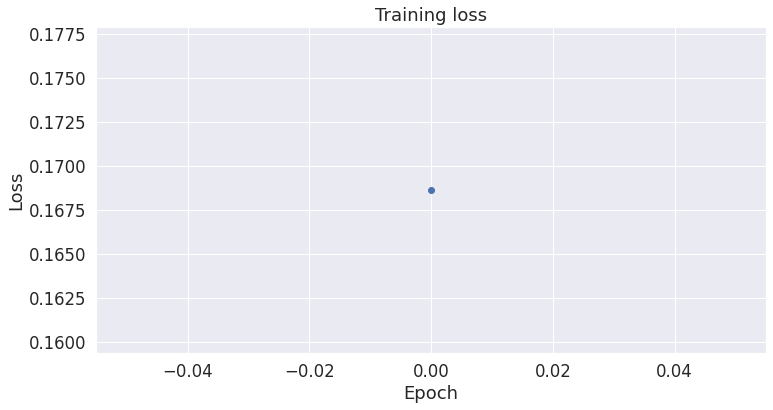

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

save the model (3rd trial run on Oct 8)

In [ ]:
output_dir = './models_saved_qqp_oct9Final/'

print("Saving model to %s" % output_dir)

model.save_pretrained(output_dir)

Saving model to ./models_saved_qqp_oct9C/
